In [1]:
import os
from scipy.signal import detrend
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces2 = cat["ECCO_layers"].to_dask()
ds_faces=xr.merge((ds_faces1,ds_faces2))

/srv/conda/envs/notebook/lib/python3.7/site-packages/fsspec/implementations/local.py:32: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [3]:
import gcsfs
basins = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-data/ECCO_basins.zarr')
                      , consolidated=True)

In [4]:
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins.basin_mask == 2,0)+ mask_2d.where(basins.basin_mask == 7,0)
              + mask_2d.where(basins.basin_mask == 9,0)
             + mask_2d.where(basins.basin_mask == 10,0)
             + mask_2d.where(basins.basin_mask == 12,0)
             + mask_2d.where(basins.basin_mask == 18,0)
             + mask_2d.where(basins.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))

basins2=basins.rename({'j':'j_g'})
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins2.basin_mask == 2,0)+ mask_2d.where(basins2.basin_mask == 7,0)
              + mask_2d.where(basins2.basin_mask == 9,0)
             + mask_2d.where(basins2.basin_mask == 10,0)
             + mask_2d.where(basins2.basin_mask == 12,0)
             + mask_2d.where(basins2.basin_mask == 18,0)
             + mask_2d.where(basins2.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))

basins3=basins.rename({'i':'i_g'})
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins3.basin_mask == 2,0)+ mask_2d.where(basins3.basin_mask == 7,0)
              + mask_2d.where(basins3.basin_mask == 9,0)
             + mask_2d.where(basins3.basin_mask == 10,0)
             + mask_2d.where(basins3.basin_mask == 12,0)
             + mask_2d.where(basins3.basin_mask == 18,0)
             + mask_2d.where(basins3.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [5]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [6]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [7]:
#Want to justify the existence of l3_c* by plotting the volume transport of the lattitude j_g = 220 in depth coordinates
v = (ds.VVELMASS*ds.atl_maskS)#.mean('time')[:, 220, :]
v1 = (ds.VVELMASS * ds.atl_maskS).where(coords.hFacS == 1)
sigma = (ds.LaHs3RHO*ds.atl_maskS).mean('time').isel(j_g=220)[:103, ].sum('l3_c')[140:230]

In [8]:
velocity = v1.mean('time')
longitude = ds.i + 110

In [9]:
velocity.load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (k: 50, j_g: 270, i: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


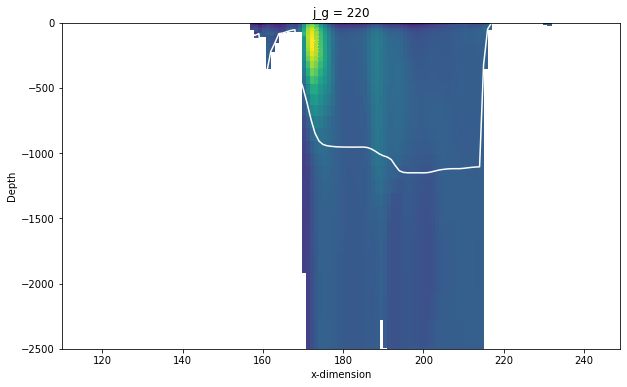

In [12]:
fig, ax = pltt.subplots(figsize=(10,6))
(-1*sigma).plot(ax=ax, color='white')
pltt.ylabel('Depth')
pltt.xlabel('x-dimension')
pltt.ylim(-2500, 0)
#pltt.contourf(coords.XC[170:260,110:300],coords.YG[170:260,110:300],THETA_jg[0,0,170:260,110:300].values)
pltt.pcolor(ds.i[110:250].values,coords.Z.values, v1.mean('time')[:, :, 110:250].isel(j_g=220).values)
#ax.pcolor(ds.i[155:220].values,coords.Z.values, v1.mean('time')[:, :, 140:230].isel(j_g=220).values)

ValueError: x and y must have same first dimension, but have shapes (75,) and (90,)

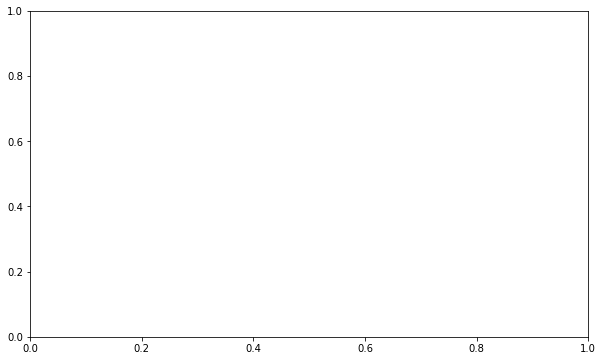

In [26]:
fig, ax = pltt.subplots(figsize=(10,6))
#(-1*sigma).plot(ax=ax, color='white')
pltt.plot(coords.XC[220, 145:220].values, -1*sigma.values)
pltt.ylabel('Depth')
pltt.xlabel('x-dimension')
pltt.ylim(-4000, 0)
pltt.xlim(-70,5)
pltt.contourf(coords.XC[220, 145:220].values, coords.Z.values, v1.mean('time')[:, :, 145:220].isel(j_g=220).values)
pltt.colorbar()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


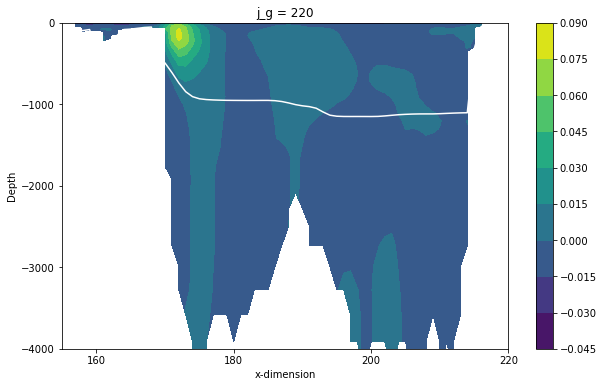

In [10]:
fig, ax = pltt.subplots(figsize=(10,6))
(-1*sigma).plot(ax=ax, color='white')
pltt.ylabel('Depth')
pltt.xlabel('x-dimension')
pltt.ylim(-4000, 0)
pltt.xlim(155, 220)
pltt.contourf(ds.i[145:220].values,coords.Z.values, v1.mean('time')[:, :, 145:220].isel(j_g=220).values)
pltt.colorbar()
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


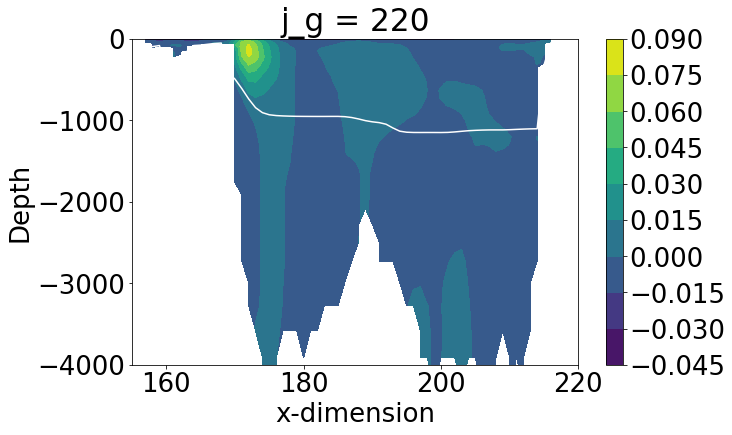

In [12]:
fig, ax = pltt.subplots(figsize=(10,6))
(-1*sigma).plot(ax=ax, color='white')
pltt.ylabel('Depth')
pltt.xlabel('x-dimension')
pltt.ylim(-4000, 0)
pltt.xlim(155, 220)
pltt.contourf(ds.i[145:220].values,coords.Z.values, v1.mean('time')[:, :, 145:220].isel(j_g=220).values)
pltt.colorbar()
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

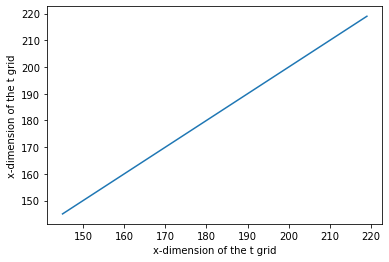

In [22]:
ds.i[145:220].plot()